In [0]:
# a = []
# while(1):
#     a.append('1')

In [0]:
!pip install -U -q kaggle
!mkdir ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikunjgoel","key":"4d4b8ceb591a64c1ae4e80996446b150"}'}

In [0]:
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c 11-785-s20-hw2p2-classification

 98% 576M/589M [00:05<00:00, 152MB/s]
100% 589M/589M [00:05<00:00, 119MB/s]
  0% 0.00/53.9k [00:00<?, ?B/s]
100% 53.9k/53.9k [00:00<00:00, 56.7MB/s]


In [0]:
!unzip 11-785-hw2p2-s20.tgz.zip
!tar zxvf 11-785-hw2p2-s20.tgz
!unzip /content/11-785hw2p2-s20/train_data.zip
!unzip /content/11-785hw2p2-s20/validation_classification.zip
!unzip /content/11-785hw2p2-s20/test_classification.zip

Streaming output truncated to the last 5000 lines.
   creating: validation_classification/medium/94/
  inflating: validation_classification/medium/94/0.jpg  
  inflating: validation_classification/medium/94/1.jpg  
   creating: validation_classification/medium/423/
  inflating: validation_classification/medium/423/0.jpg  
  inflating: validation_classification/medium/423/1.jpg  
   creating: validation_classification/medium/287/
  inflating: validation_classification/medium/287/0.jpg  
  inflating: validation_classification/medium/287/1.jpg  
   creating: validation_classification/medium/1442/
  inflating: validation_classification/medium/1442/0.jpg  
  inflating: validation_classification/medium/1442/1.jpg  
   creating: validation_classification/medium/1781/
  inflating: validation_classification/medium/1781/0.jpg  
  inflating: validation_classification/medium/1781/1.jpg  
   creating: validation_classification/medium/25/
  inflating: validation_classification/medium/25/0.jpg  
  in

In [0]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.optim as optim
import time

In [0]:
# Use torch ImageFolder
data_transform = transforms.Compose([
        #transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
face_dataset = datasets.ImageFolder(root='/content/train_data/medium/',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(face_dataset,
                                             batch_size=512,
                                             shuffle=True,
                                             num_workers=8)
faceVal_dataset = datasets.ImageFolder(root='/content/validation_classification/medium/',
                                           transform=data_transform)
val_loader = torch.utils.data.DataLoader(faceVal_dataset,
                                             batch_size=512,
                                             shuffle=False,
                                             num_workers=8)

In [0]:
dataset_loader.dataset

Dataset ImageFolder
    Number of datapoints: 822155
    Root location: /content/train_data/medium/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [0]:
# count = 0
# for x,y in dataset_loader:
#     x = x.numpy()
#     print(x.shape)
#     for img, label in zip(x,y):
#         print("Label: {}".format(label))
#         plt.imshow(img.transpose((1,2,0)))
#         plt.show()
#         if count == 3:
#           break
#         else:
#           count = count + 1 

In [0]:
class BasicCNNModule(nn.Module):
    def __init__(self):
        super(BasicCNNModule, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 24 * 24, 9200)
        self.fc2 = nn.Linear(9200, 2300)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
print(BasicCNNModule())

BasicCNNModule(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=9200, bias=True)
  (fc2): Linear(in_features=9200, out_features=2300, bias=True)
)


In [0]:
model = BasicCNNModule()
cuda = torch.cuda.is_available()
cuda
device = torch.device("cuda" if cuda else "cpu")
device

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'min',factor=0.1,patience=2)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

BasicCNNModule(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=9200, bias=True)
  (fc2): Linear(in_features=9200, out_features=2300, bias=True)
)


In [0]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    targetList = torch.tensor(np.array(train_loader.dataset.classes,dtype = int))
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = targetList[target].to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        if (batch_idx%1000) == 0:
              print(batch_idx,' Running Loss ',running_loss)
        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [0]:
def val_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        targetList = torch.tensor(np.array(val_loader.dataset.classes,dtype = int))
        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.to(device)
            target = targetList[target].to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Valdiation Loss: ', running_loss)
        print('Validation Accuracy: ', acc, '%')
        return running_loss, acc


In [0]:
n_epochs = 8
Train_loss = []
val_loss = []
val_acc = []

for i in range(n_epochs):
    print('Epoch Number ',i)
    train_loss = train_epoch(model, dataset_loader, criterion, optimizer)
    val_l, val_ac = val_model(model, val_loader, criterion)
    Train_loss.append(train_loss)
    val_loss.append(val_l)
    val_acc.append(val_ac)
    print('Training Loss ',train_loss,' Val Loss ',val_l,' Val acc ',val_ac)
    print('='*20)
    scheduler.step(metrics=val_l)

Epoch Number  0
0  Running Loss  5.199878692626953
1000  Running Loss  4763.131851673126
Training Loss:  4.6244064547205035 Time:  194.8581738471985 s
Valdiation Loss:  4.465076658460829
Validation Accuracy:  21.82608695652174 %
Training Loss  4.6244064547205035  Val Loss  4.465076658460829  Val acc  21.82608695652174
Epoch Number  1
0  Running Loss  3.7860679626464844
1000  Running Loss  3745.5520448684692
Training Loss:  3.7264057901104537 Time:  194.56829929351807 s
Valdiation Loss:  4.177683671315511
Validation Accuracy:  26.89130434782609 %
Training Loss  3.7264057901104537  Val Loss  4.177683671315511  Val acc  26.89130434782609
Epoch Number  2
0  Running Loss  2.7459120750427246
1000  Running Loss  3107.1512031555176
Training Loss:  3.143818394926981 Time:  194.3531060218811 s
Valdiation Loss:  4.088258213467068
Validation Accuracy:  29.41304347826087 %
Training Loss  3.143818394926981  Val Loss  4.088258213467068  Val acc  29.41304347826087
Epoch Number  3
0  Running Loss  2.57

In [0]:
import os
rootdir = '/content/test_classification/medium/'

for files in os.listdir(rootdir):
  os.mkdir(rootdir+files[:-4])
  os.replace(rootdir+files,rootdir+files[:-4]+'/'+files)

In [0]:
# Use torch ImageFolder
data_transform = transforms.Compose([
        #transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
face_dataset = datasets.ImageFolder(root='/content/test_classification/medium',
                                           transform=data_transform)
test_loader = torch.utils.data.DataLoader(face_dataset,
                                             batch_size=512,
                                             shuffle=False,
                                             num_workers=8)

In [0]:
# count = 0
# for x,y in test_loader:
#     print(x.shape)
#     print(y.data)
#     if count == 3:
#       break
#     else:
#       count = count + 1

In [0]:
targetList = torch.tensor(np.array(test_loader.dataset.classes,dtype = int))

In [0]:
targetList[1]

tensor(5001)

In [0]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        output = []
        counter = 0
        targetList = test_loader.dataset.classes
        for batch_idx, (data,target) in enumerate(test_loader):   
            data = data.to(device)
            

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            ansB = predicted.cpu().numpy()
            for i in range(ansB.shape[0]):
              output.append((targetList[target[i]]+'.jpg',ansB[i])) 
            
            
        return np.array(output)

In [0]:
ans = test_model(model, test_loader, criterion)

In [0]:
ans.shape

(4600, 2)

In [0]:
ans[179]

array(['5179.jpg', '771'], dtype='<U8')

In [0]:
import pandas as pd
finalAns = pd.DataFrame(ans,columns=['Id','Category'])
finalAns.head()

,Id,Category
0,5000.jpg,1995
1,5001.jpg,908
2,5002.jpg,1893
3,5003.jpg,1359
4,5004.jpg,571


In [0]:
finalAns.to_csv('/content/hw2_p21.csv',index=False)

In [0]:
!kaggle competitions submit -c 11-785-s20-hw2p2-classification -f hw2_p21.csv -m "Second Submission"

100% 60.8k/60.8k [00:00<00:00, 232kB/s]
Successfully submitted to 11-785, Spring 2020, HW2P2 - Classification

In [0]:
finalAns['Category'].nunique()

2001

In [0]:
model

BasicCNNModule(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=9200, bias=True)
  (fc2): Linear(in_features=9200, out_features=2300, bias=True)
)

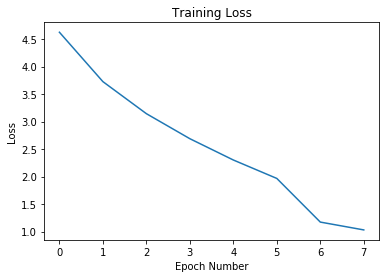

In [0]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

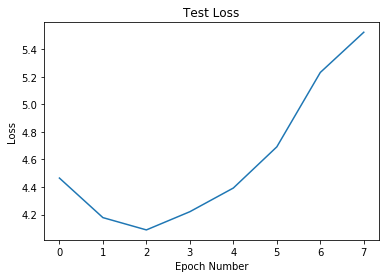

In [0]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(val_loss)


In [0]:
torch.save({
            'epoch': n_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': train_loss,
            'Testing Loss' : val_loss,
            'Testing Accuracy': val_acc
            }, '/content/drive/My Drive/trained_model.pth')

In [0]:
model.state_dict()['conv1.weight']

tensor([[[[-1.6522e-01, -3.5627e-03, -1.0982e-01,  1.1133e-01,  7.9051e-02],
          [-1.1785e-01, -1.7726e-01, -2.2405e-02, -6.9367e-02, -8.7212e-02],
          [-2.4032e-02, -2.0428e-01,  1.0644e-02,  1.3691e-01,  9.5820e-02],
          [ 3.6543e-03, -6.5594e-02,  1.5187e-01,  3.6710e-02,  6.9255e-02],
          [-1.3692e-03,  9.4821e-02,  9.3777e-02,  6.3912e-02, -1.0311e-02]],

         [[-3.9115e-02,  8.7788e-02,  1.4275e-01, -1.0028e-02,  2.2630e-02],
          [ 1.7826e-02, -1.0589e-01, -7.3896e-02,  1.4240e-01, -5.3120e-02],
          [ 6.1148e-03, -2.4318e-01,  8.7950e-03,  5.7547e-02,  8.6665e-02],
          [-1.2720e-02,  5.7998e-02,  8.8273e-02,  1.2336e-01,  5.1141e-02],
          [-7.2792e-02,  2.5378e-02,  5.4685e-02, -8.3683e-02, -1.4667e-01]],

         [[-3.5823e-02,  8.5236e-02,  7.6564e-02,  3.7468e-02, -7.7220e-02],
          [ 9.1374e-02, -5.0104e-03,  1.2739e-02,  9.1343e-02,  6.5313e-02],
          [-1.3238e-01, -1.4999e-01, -1.4691e-01,  1.3582e-01,  6.6185e-